Load thư viện

In [ ]:
import pandas as pd
import csv 
import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.utils import to_categorical
from keras.callbacks import TensorBoard, Callback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

Load dataset

In [ ]:
train_df = pd.read_csv(r"dataset/train-0.csv", header=None, skiprows=1).sample(frac=1)
val_df = pd.read_csv(r"dataset/file-0.csv", header=None, skiprows=1).sample(frac=1)
test_df = pd.read_csv(r"dataset/file-1.csv", header=None, skiprows=1).sample(frac=1)

print(train_df)

                                                    0          1     ...  1909  1910
18296               d8f7cd8ce0c182680e8b3c48a2bd47ee.apk  GoldDream  ...     0     0
4471                d232f20d95f97147c36ec246c8a140a6.apk      Zitmo  ...     1     1
8511                0fdb82f51f72b80c7b862d5b7b223817.apk   FakeInst  ...     0     0
7503   da850ba392227c23b4881a49cc9bd3a138dba9e595a23e...     Opfake  ...     0     0
8052                319fc149dd63e02ffc8021afd34bd410.apk    BankBot  ...     0     0
...                                                  ...        ...  ...   ...   ...
432                            Turbo Booster PRO-313.apk     0_apps  ...     1     1
13037         AndroVid Pro Video Editor v280 Patched.apk     0_apps  ...     1     1
14058               725ce49962687a883d3bba7dac0b8076.apk    Airpush  ...     1     1
5924                1adc8f47e1cff826a2d51a163ea9aeda.apk      Mecor  ...     0     0
11600               c9373be25e3ca594b352f42e370576b9.apk     Dowg

Lọc đặc trưng và nhãn từ dataset

In [ ]:
train_y = np.array(train_df.iloc[:, 2]) #lấy cột 2 là cột nhãn 
train_x = np.array(train_df.iloc[:,3:]) #lấy cột 3 làm đặc trưng
train_x = np.concatenate((train_x, np.zeros((train_x.shape[0],28))),1) #thêm padding các số 0 vào để tạo thành ma trạn vuông.
unique, counts = np.unique(train_y, return_counts=True)
print("LABEL TRAIN: ", len(unique))

val_y = np.array(val_df.iloc[:, 2]) #lấy cột 2 là cột nhãn 
val_x = np.array(val_df.iloc[:,3:]) #lấy cột 3 làm đặc trưng
val_x = np.concatenate((val_x, np.zeros((val_x.shape[0], 28))), 1) #thêm padding các số 0 vào để tạo thành ma trạn vuông.
unique_v, counts_ = np.unique(val_y, return_counts=True)
print("LABEL VAL: ", len(unique_v))

test_y = np.array(test_df.iloc[:, 2]) #lấy cột 2 là cột nhãn 
test_x = np.array(test_df.iloc[:,3:]) #lấy cột 3 làm đặc trưng
test_x = np.concatenate((test_x, np.zeros((test_x.shape[0], 28))), 1) #thêm padding các số 0 vào để tạo thành ma trạn vuông.
unique_t, counts_t = np.unique(test_y, return_counts=True)
print("LABEL TEST: ", len(unique_t))


LABEL TRAIN:  156
LABEL VAL:  222
LABEL TEST:  179


Khởi tạo các hằng số của mô hình

In [ ]:
BATCH_SIZE = 32
SIZE = 44
N_CLASSES = 228
LR = 0.001
N_EPOCHS = 15

print(train_x.shape,train_y.shape)
print(val_x.shape,val_y.shape)
print(test_x.shape,test_y.shape)

(25713, 1936) (25713,)
(3260, 1936) (3260,)
(3217, 1936) (3217,)


Tranform dữ liệu về ma trận phù hợp

In [ ]:
train_x = train_x.reshape(train_x.shape[0],SIZE, SIZE, 1)
val_x = val_x.reshape(val_x.shape[0],SIZE, SIZE, 1)
test_x = test_x.reshape(test_x.shape[0],SIZE, SIZE, 1)

LABELS = np.unique(train_y)
original_test_y = test_y

train_y = to_categorical(train_y, N_CLASSES)
val_y = to_categorical(val_y, N_CLASSES)
test_y = to_categorical(test_y, N_CLASSES)

print(LABELS)

[  0   1   4   5   6  12  13  15  18  22  24  25  26  31  32  33  34  35
  36  39  40  41  42  43  44  46  47  48  49  51  52  54  56  58  60  62
  63  64  66  67  68  69  71  72  73  74  75  76  77  78  79  83  84  85
  87  88  89  92  95  98 100 102 104 106 108 109 110 111 112 116 117 120
 121 123 124 125 126 130 132 133 134 139 142 145 148 149 150 151 152 153
 155 156 157 158 160 161 163 164 166 167 169 171 172 173 175 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227]


Khởi tạo mô hình CNN cho api + per

In [ ]:
input0 = Input(shape=(SIZE,SIZE,1))
conv1 = Conv2D(32, kernel_size=2, activation='relu', padding="same" ,input_shape=(SIZE, SIZE, 1))(input0)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(32, kernel_size=2, activation='relu', padding="same")(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
'''
conv4 = Conv2D(64, kernel_size=2, activation='relu', padding="same")(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
'''
flatten_per = Flatten()(pool3)

hidden1 = Dense(1024, activation='relu')(flatten_per)
output = Dense(N_CLASSES, activation='softmax')(hidden1)

model = Model(inputs=input0, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Tạo lớp callback khi train

In [ ]:
class Metrics(Callback):
    def __init__(self, x, y):
        self.x = x
        self.y = y if (y.ndim == 1 or y.shape[1] == 1) else np.argmax(y, axis=1)
        self.reports = []

    def on_epoch_end(self, epoch, logs={}):
        y_hat = np.asarray(self.model.predict(self.x))
        y_hat = np.where(y_hat > 0.5, 1, 0) if (y_hat.ndim == 1 or y_hat.shape[1] == 1)  else np.argmax(y_hat, axis=1)
        report = classification_report(self.y,y_hat,output_dict=True)
        self.reports.append(report)
        return
   
    # Utility method
    def get(self, metrics, of_class):
        return [report[str(of_class)][metrics] for report in self.reports]

Trainning

In [ ]:
metrics_multiclass = Metrics(train_x, train_y)
history = model.fit(train_x, train_y, epochs=N_EPOCHS, batch_size = BATCH_SIZE ,validation_data=(val_x, val_y), callbacks=[metrics_multiclass])

Epoch 1/15
804/804 [==============================] - 37s 9ms/step - loss: 0.8085 - accuracy: 0.8067 - val_loss: 0.6877 - val_accuracy: 0.8837
Epoch 2/15
 13/804 [..............................] - ETA: 6s - loss: 0.2358 - accuracy: 0.9351

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


804/804 [==============================] - 7s 9ms/step - loss: 0.2179 - accuracy: 0.9319 - val_loss: 0.5713 - val_accuracy: 0.9110
Epoch 3/15
804/804 [==============================] - 7s 9ms/step - loss: 0.1325 - accuracy: 0.9515 - val_loss: 0.5917 - val_accuracy: 0.9141
Epoch 4/15
804/804 [==============================] - 7s 9ms/step - loss: 0.0979 - accuracy: 0.9618 - val_loss: 0.5292 - val_accuracy: 0.9126
Epoch 5/15
804/804 [==============================] - 7s 9ms/step - loss: 0.0845 - accuracy: 0.9643 - val_loss: 0.5272 - val_accuracy: 0.9258
Epoch 6/15
804/804 [==============================] - 7s 9ms/step - loss: 0.0693 - accuracy: 0.9696 - val_loss: 0.5761 - val_accuracy: 0.9236
Epoch 7/15
804/804 [==============================] - 7s 9ms/step - loss: 0.0726 - accuracy: 0.9690 - val_loss: 0.6211 - val_accuracy: 0.9212
Epoch 8/15
804/804 [==============================] - 7s 9ms/step - loss: 0.0654 - accuracy: 0.9718 - val_loss: 0.5572 - val_accuracy: 0.9276
Epoch 9/15
804/80

In kết quả acc thành đồ thị

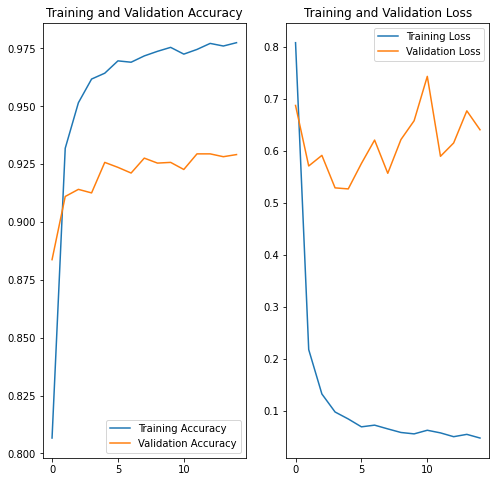

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(N_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('/content/drive/My Drive/test.png')
plt.close('all')

In [1]:
#save model & convert to tflite
# model.save('AMD_Benign_ver2.h5')
import tensorflow as tf
h5_model = tf.keras.models.load_model('/content/drive/MyDrive/output/per_api_amd_drebin_benign/train-0/model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(h5_model)
tflite_model = converter.convert()
open("AMDDrebinModel.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgd5mrag_/assets


7546540

<Figure size 432x288 with 0 Axes>

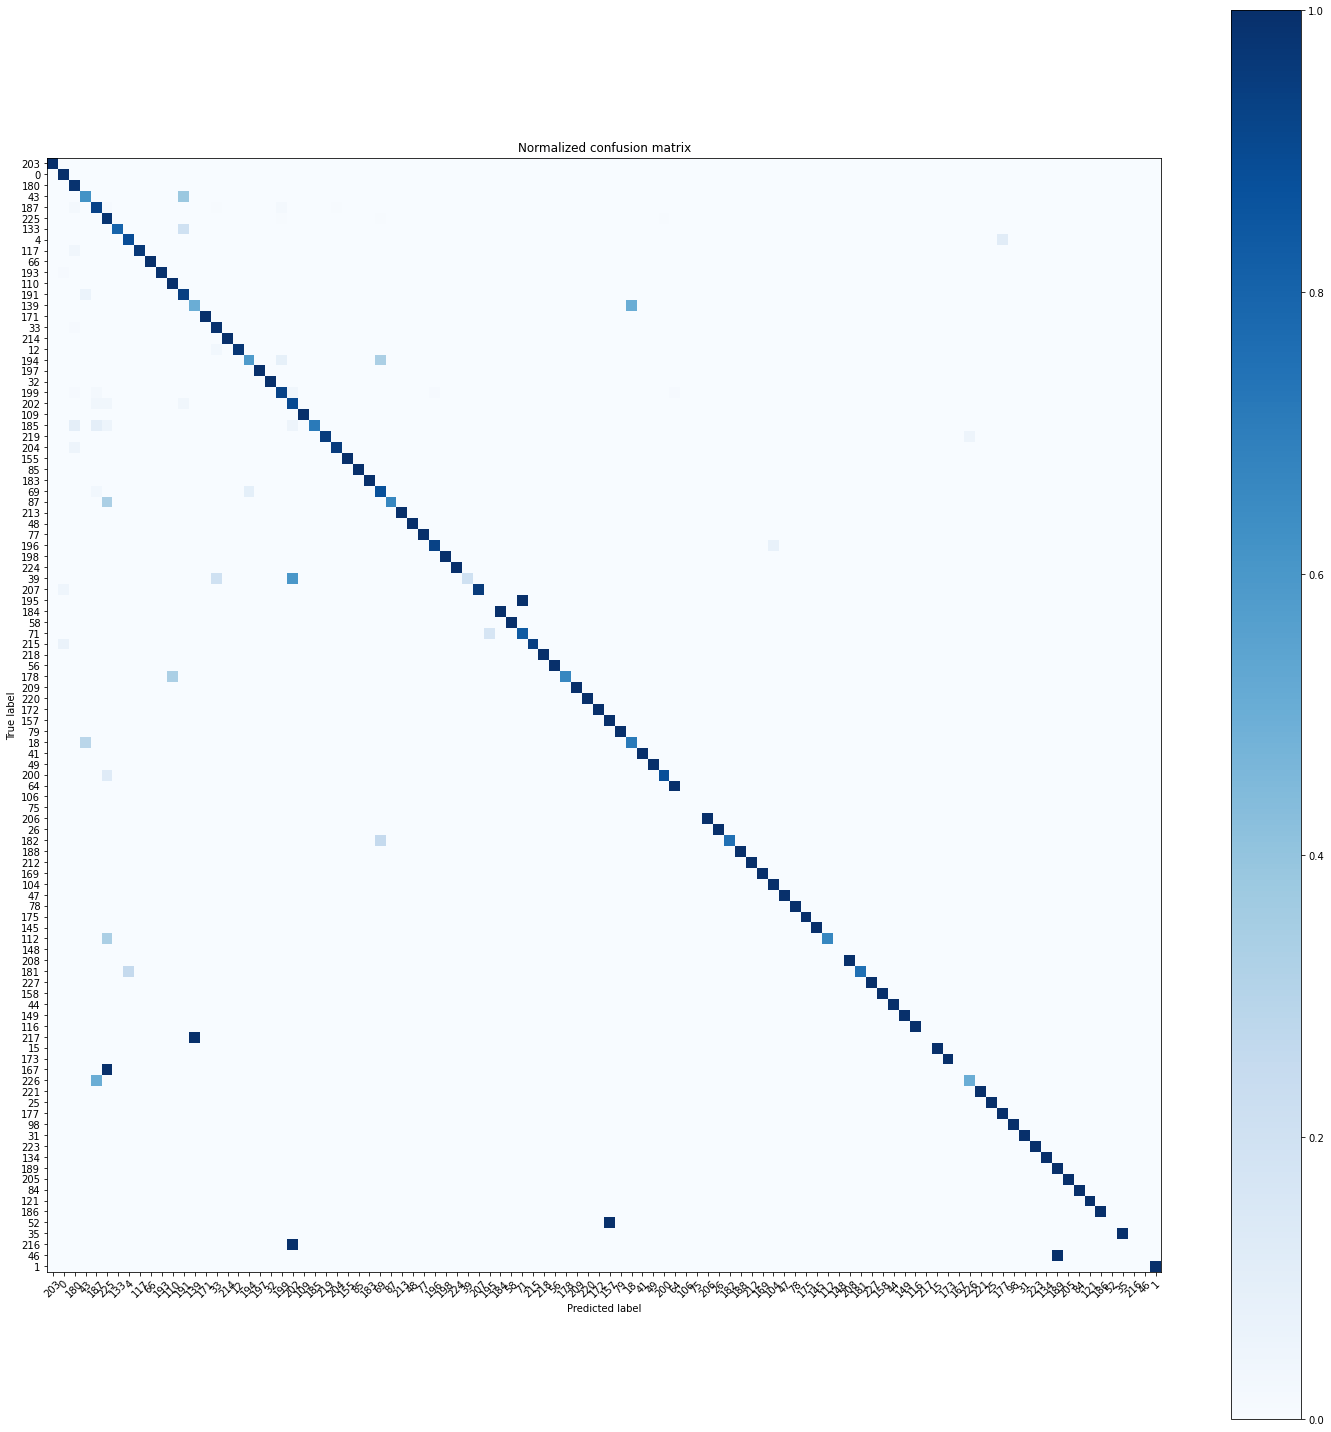

0.9493630573248407
0.8127766619043229
0.8019088948893317
0.800187302163829


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tmp = list(dict.fromkeys(original_test_y))
y_pred1 = model.predict(test_x)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
cnf_matrix=confusion_matrix(original_test_y, y_pred, labels=tmp, normalize='true')
plt.close('all')
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=tmp, title='Normalized confusion matrix')

plt.show()
plt.close('all')


print(accuracy_score(original_test_y, y_pred))
print(precision_score(original_test_y, y_pred , average="macro"))
print(recall_score(original_test_y, y_pred , average="macro"))
print(f1_score(original_test_y, y_pred , average="macro"))

In [ ]:
report = classification_report(original_test_y, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)
print(classification_report(original_test_y, y_pred, output_dict=True))

              precision    recall  f1-score      support
0              0.992658  0.998523  0.995582   677.000000
1              1.000000  1.000000  1.000000     1.000000
4              0.888889  0.888889  0.888889     9.000000
12             1.000000  0.968750  0.984127    32.000000
15             1.000000  1.000000  1.000000     1.000000
...                 ...       ...       ...          ...
226            0.500000  0.500000  0.500000     2.000000
227            1.000000  1.000000  1.000000     1.000000
accuracy       0.949363  0.949363  0.949363     0.949363
macro avg      0.812777  0.801909  0.800187  3140.000000
weighted avg   0.950109  0.949363  0.947897  3140.000000

[111 rows x 4 columns]
{'0': {'precision': 0.9926578560939795, 'recall': 0.9985228951255539, 'f1-score': 0.9955817378497791, 'support': 677}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, '4': {'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1-score': 0.8888888888888888, '

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1